In [1]:
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
import lsst.daf.butler as dB
import yaml
import sys
import numpy as np
sys.path.append("/home/czw/")
from plotUtils import plotCameraOutline, plotCcdOutline
from collections import defaultdict
from pprint import pprint
import astrowidgets

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [15]:
calibType = 'dark'
cameraName = 'LATISS'
verifyCollection = 'u/czw/DM-28920/verifyDark.20210707d'

In [16]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[verifyCollection])
camera = butler.get('camera', instrument=cameraName)

In [17]:
# Get Run Statistics
runStats = butler.get('verifyDarkStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [18]:
IW = astrowidgets.ImageWidget(image_width=1000, image_height=1000)

In [19]:
calib = butler.get(calibType, instrument=cameraName, detector=0)
calibArray = calib.getImage().getArray()

Median: 0.008738398551940918   Stdev: 0.056134360190480945


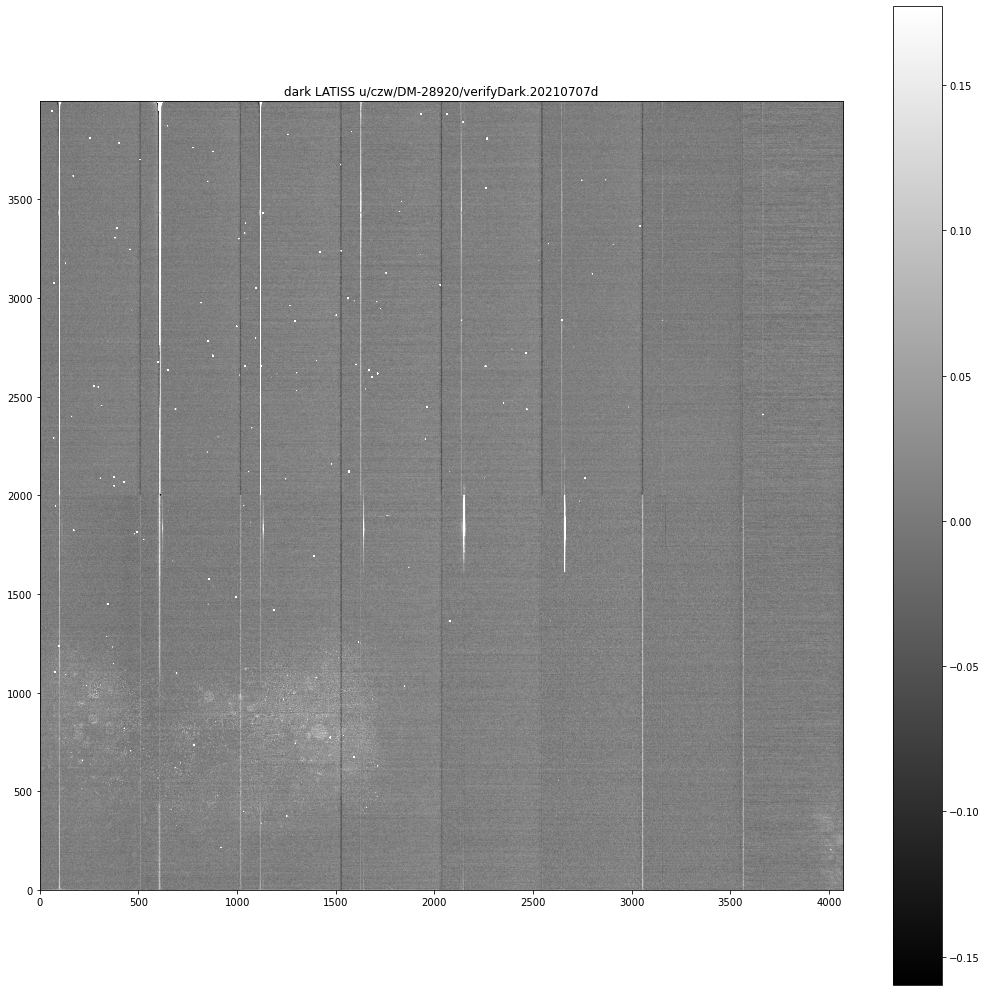

In [20]:
# Get simple stats
q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
sigma = 0.74 * (q75 - q25)
print(f"Median: {q50}   Stdev: {sigma}")
IW.load_array(calibArray)
# Plot it.
plt.figure(figsize=(18, 18))
plt.imshow(calibArray, vmin=q50 - 3*sigma, vmax=q50+ 3*sigma, cmap='gray', origin='lower')
plt.title(f"{calibType} {cameraName} {verifyCollection}")
plt.colorbar()

In [21]:
IW

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [22]:
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    for exposureId, stats in runStats.items():
        residual = butler.get('verifyDarkProc', instrument=cameraName, exposure=exposureId, detector=0)
        detStats = butler.get('verifyDarkDetStats', instrument=cameraName, exposure=exposureId, detector=0)
        IW.load_array(residual.getImage().getArray())
        while True:
            ans = input(f"{exposureId} Continue? [c, q]").lower()
            if ans in ("", "c",):
                break
            if ans in ('q', 'x'):
                continueDisplay = False
                break
            if ans in ('p'):
                pprint(detStats)
                break
        if continueDisplay is False:
            break

2021011900151 Continue? [c, q]
2021011900152 Continue? [c, q]
2021011900153 Continue? [c, q]p
{'AMP': {'C00': {'CR_NOISE': 29.585907816503738,
                 'MEAN': 0.1958192200046229,
                 'NOISE': 9.28469189158766},
         'C01': {'CR_NOISE': 10.023329681748383,
                 'MEAN': 0.5682104865586869,
                 'NOISE': 9.833764319956016},
         'C02': {'CR_NOISE': 9.670198042070023,
                 'MEAN': 0.46964158691862573,
                 'NOISE': 9.576731355731098},
         'C03': {'CR_NOISE': 9.370801606049348,
                 'MEAN': 0.6772683638318784,
                 'NOISE': 9.322056801470598},
         'C04': {'CR_NOISE': 9.787826319392765,
                 'MEAN': 1.2328824160648926,
                 'NOISE': 9.729530866406169},
         'C05': {'CR_NOISE': 10.673918193961793,
                 'MEAN': 0.7584398839185458,
                 'NOISE': 10.539393533531259},
         'C06': {'CR_NOISE': 10.228306520234135,
                 'M

<ipython-input-23-509ce2ee9c4b>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ampNames, rotation=45, rotation_mode='anchor', ha='right')


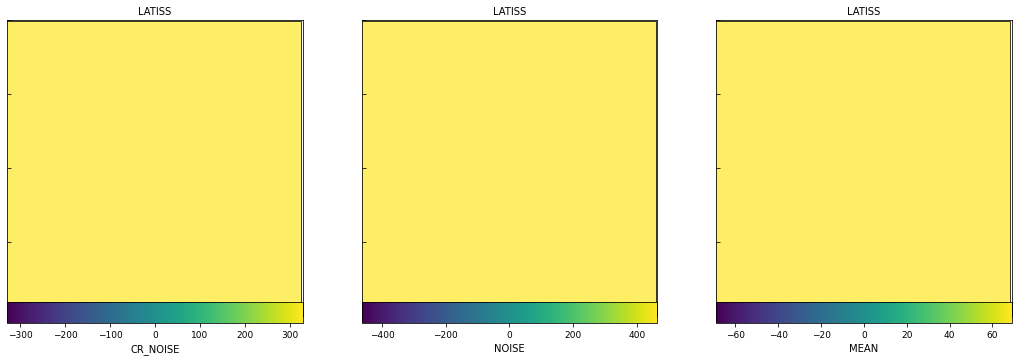

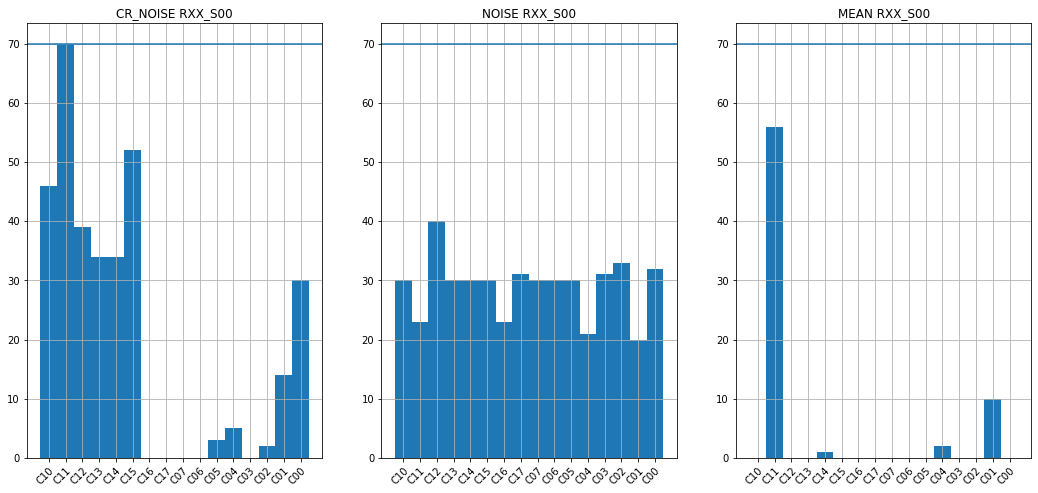

In [23]:
if runSuccess is False:
    numExposures = len(runStats.keys())
    # I probably should rethink the structure if I need to do this much work.
    failedTests = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) # test -> detector -> amp -> list of exposure #
    for exposure, stats in runStats.items():
        failures = stats['FAILURES']
        for failure in failures:
            detector, amp, test = failure.split(" ")
            failedTests[test][detector][amp].append(exposure)

    # Focal plane plots
    numTests = len(failedTests.keys())
    fig, axes = plt.subplots(1, numTests, figsize=(numTests * 6, 8))   
    for axis, (testName, failureSet) in zip(axes, failedTests.items()):
        # full camera 
        ccdList = list(set([camera[detName].getId() for detName in failureSet.keys()]))

        metricPerCcdDict = defaultdict(float)
        for detName, detFails in failureSet.items():
            detId = camera[detName].getId()
            for amp, expList in detFails.items():
                metricPerCcdDict[str(detId)] += len(expList)

        axis.set_aspect("equal")
        plotCameraOutline(axis, camera, list(metricPerCcdDict.keys()), 
                          metricPerCcdDict=metricPerCcdDict, metricStr=testName, fig=fig, fontSize=10)
        
    fig, axes = plt.subplots(1, numTests, figsize=(numTests * 6, 8))
    for axis, (testName, failureSet) in zip(axes, failedTests.items()):
        for detName, detFails in failureSet.items():
            detector = camera[detName]
            # Plot Nfailures / chip / amp
            ampNames = [amp.getName() for amp in detector]
            ampValues = [len(detFails.get(ampName, [])) for ampName in ampNames]
            bins = list(map(lambda x: x-0.5, range(1,len(ampNames)+1)))
            
            axis.bar(ampNames, ampValues, width=1.0)
            axis.axhline(numExposures)
            axis.set_title(f"{testName} {detName}")
            axis.set_xticklabels(ampNames, rotation=45, rotation_mode='anchor', ha='right')
            axis.grid()

In [24]:
config = butler.get('isr_config')
config.toDict()

{'saveMetadata': True,
 'datasetType': 'raw',
 'fallbackFilterName': None,
 'useFallbackDate': False,
 'expectWcs': True,
 'fwhm': 1.0,
 'qa': {'saveStats': True,
  'flatness': {'meshX': 256,
   'meshY': 256,
   'doClip': True,
   'clipSigma': 3.0,
   'nIter': 3},
  'doWriteOss': False,
  'doThumbnailOss': False,
  'doWriteFlattened': False,
  'doThumbnailFlattened': False,
  'thumbnailBinning': 4,
  'thumbnailStdev': 3.0,
  'thumbnailRange': 5.0,
  'thumbnailQ': 20.0,
  'thumbnailSatBorder': 2},
 'doConvertIntToFloat': True,
 'doSaturation': True,
 'saturatedMaskName': 'SAT',
 'saturation': nan,
 'growSaturationFootprintSize': 1,
 'doSuspect': False,
 'suspectMaskName': 'SUSPECT',
 'numEdgeSuspect': 0,
 'edgeMaskLevel': 'DETECTOR',
 'doSetBadRegions': True,
 'badStatistic': 'MEANCLIP',
 'doOverscan': True,
 'overscan': {'fitType': 'MEDIAN_PER_ROW',
  'order': 1,
  'numSigmaClip': 3.0,
  'maskPlanes': ['SAT'],
  'overscanIsInt': True},
 'overscanFitType': 'MEDIAN',
 'overscanOrder': 1,

In [25]:
runStats

{2021011900151: {'FAILURES': ['RXX_S00 C00 CR_NOISE',
   'RXX_S00 C00 NOISE',
   'RXX_S00 C01 CR_NOISE',
   'RXX_S00 C01 NOISE',
   'RXX_S00 C02 NOISE',
   'RXX_S00 C03 NOISE',
   'RXX_S00 C04 CR_NOISE',
   'RXX_S00 C05 NOISE',
   'RXX_S00 C06 NOISE',
   'RXX_S00 C07 NOISE',
   'RXX_S00 C10 NOISE',
   'RXX_S00 C11 CR_NOISE',
   'RXX_S00 C11 MEAN',
   'RXX_S00 C11 NOISE',
   'RXX_S00 C12 CR_NOISE',
   'RXX_S00 C12 NOISE',
   'RXX_S00 C13 CR_NOISE',
   'RXX_S00 C13 NOISE',
   'RXX_S00 C14 CR_NOISE',
   'RXX_S00 C14 NOISE',
   'RXX_S00 C15 CR_NOISE',
   'RXX_S00 C15 NOISE',
   'RXX_S00 C16 NOISE',
   'RXX_S00 C17 NOISE']},
 2021011900152: {'FAILURES': ['RXX_S00 C00 CR_NOISE',
   'RXX_S00 C00 NOISE',
   'RXX_S00 C02 NOISE',
   'RXX_S00 C03 NOISE',
   'RXX_S00 C05 NOISE',
   'RXX_S00 C06 NOISE',
   'RXX_S00 C07 NOISE',
   'RXX_S00 C10 CR_NOISE',
   'RXX_S00 C10 NOISE',
   'RXX_S00 C11 CR_NOISE',
   'RXX_S00 C11 MEAN',
   'RXX_S00 C11 NOISE',
   'RXX_S00 C12 CR_NOISE',
   'RXX_S00 C12 NOISE'

In [30]:
procStats = butler.get('verifyDarkApply_metadata', instrument=cameraName, exposure=exposureId, detector=0)
pprint(procStats.toDict())

{'quantum': {'endBlockInputs': 0,
             'endBlockOutputs': 0,
             'endCpuTime': 9.728584871,
             'endInvoluntaryContextSwitches': 14,
             'endMajorPageFaults': 0,
             'endMaxResidentSetSize': 1579268,
             'endMinorPageFaults': 101900,
             'endSystemTime': 0.797708,
             'endUserTime': 8.930926,
             'endUtc': '2021-07-07T22:08:54.938450',
             'endVoluntaryContextSwitches': 215,
             'initBlockInputs': 0,
             'initBlockOutputs': 0,
             'initCpuTime': 0.10673881,
             'initInvoluntaryContextSwitches': 0,
             'initMajorPageFaults': 0,
             'initMaxResidentSetSize': 314844,
             'initMinorPageFaults': 6244,
             'initSystemTime': 0.035251,
             'initUserTime': 0.07150999999999999,
             'initUtc': '2021-07-07T22:08:44.251026',
             'initVoluntaryContextSwitches': 106,
             'prepBlockInputs': 0,
             '

In [ ]:
# Get data for mean(darkTime) plot.
ampMeans = {}
detector = camera[0]
for amp in detector.getAmplifiers():
    ampMeans[amp.getName()] = {'DARKTIME': [], 'MEAN': []}

for exposureId, stats in runStats.items():
    residual = butler.get('verifyDarkProc', instrument=cameraName, exposure=exposureId, detector=0)
    detStats = butler.get('verifyDarkDetStats', instrument=cameraName, exposure=exposureId, detector=0)
    darkTime = residual.getInfo().getVisitInfo().getDarkTime()
    
    for amp in detector.getAmplifiers():
        mean = detStats['AMP'][amp.getName()]['MEAN']
        ampMeans[amp.getName()]['DARKTIME'].append(darkTime)
        ampMeans[amp.getName()]['MEAN'].append(mean)

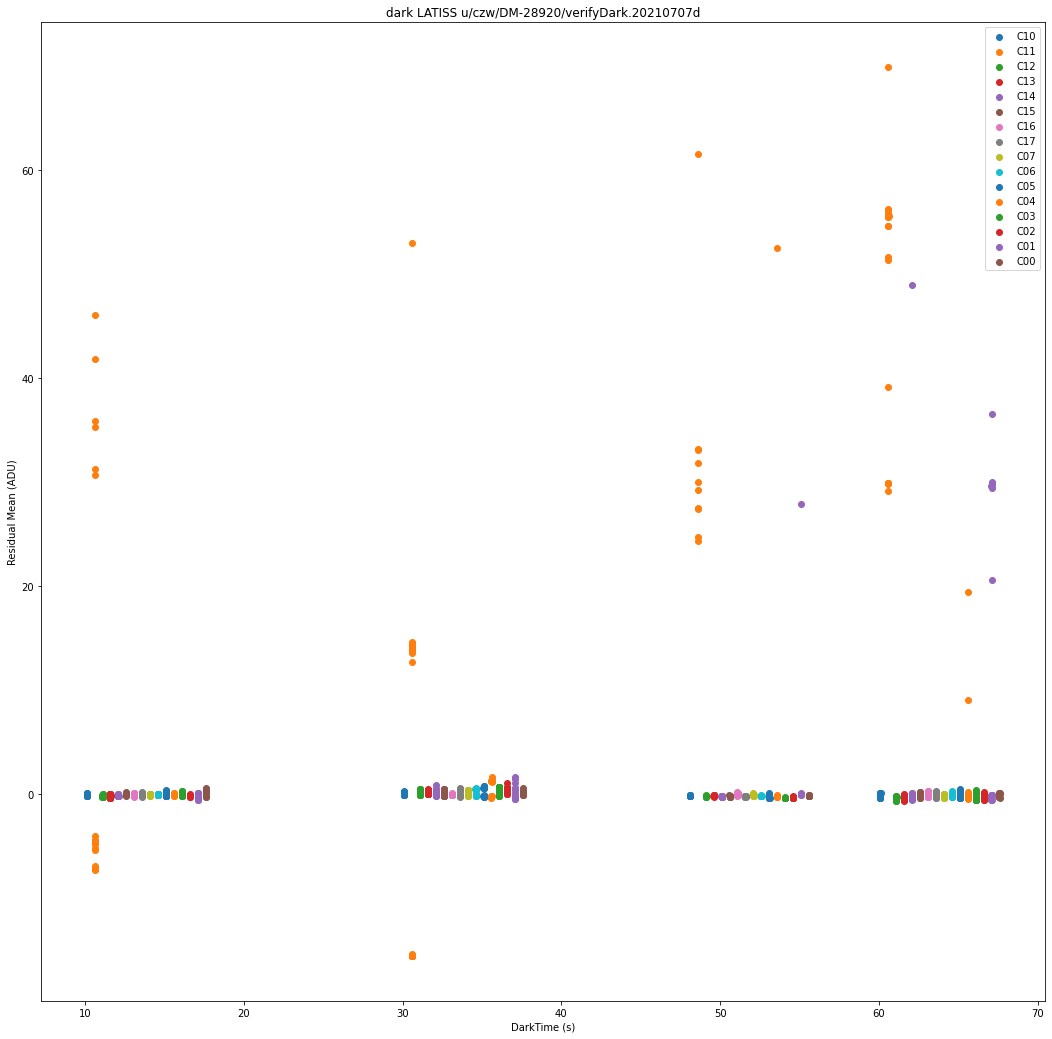

In [42]:
# plot mean as a function of exposure time, to confirm the residual is flat.
pointSpace = 0.5
plt.figure(figsize=(18, 18))
for spacer, amp in enumerate(detector.getAmplifiers()):
    plt.scatter(np.array(ampMeans[amp.getName()]['DARKTIME']) + pointSpace * spacer,
                ampMeans[amp.getName()]['MEAN'],
                label=amp.getName())
plt.xlabel("DarkTime (s)")
plt.ylabel("Residual Mean (ADU)")
plt.title(f"{calibType} {cameraName} {verifyCollection}")
plt.legend()